In [1]:
# %load_ext autoreload
# %autoreload 2
import numpy as np
import matplotlib.pyplot as plt

from orqviz.scans import (
    perform_1D_interpolation,
    perform_2D_interpolation,
    perform_2D_scan,
    eval_points_on_path,
    eval_points_on_grid,
    plot_1D_scan_result,
    plot_1D_interpolation_result,
    plot_2D_interpolation_result,
    plot_2D_scan_result,
    plot_2D_scan_result_as_3D,
    clone_Scan1DResult_with_different_values, 
    clone_Scan2DResult_with_different_values,
)
from orqviz.plots import (
    plot_optimization_trajectory,
    plot_scatter_points,
    plot_line_through_points,
)
from orqviz.hessians import (
    get_Hessian,
    get_Hessian_SPSA_approx,
    perform_1D_hessian_eigenvector_scan, 
    plot_1D_hessian_eigenvector_scan_result,
)
from orqviz.pca import (
    get_pca,
    perform_2D_pca_scan,
    plot_pca_landscape,
    plot_scatter_points_on_pca,
    plot_optimization_trajectory_on_pca,
    plot_line_through_points_on_pca,
)
from orqviz.geometric import (
    relative_periodic_wrap, 
    relative_periodic_trajectory_wrap, 
    get_random_normal_vector,
    get_random_orthonormal_vector,
)
from orqviz.plot_utils import normalize_color_and_colorbar, get_colorbar_from_ax
from orqviz.gradients import calculate_full_gradient
from orqviz.elastic_band import (
    run_AutoNEB,
    run_NEB,
    Chain,
    ChainPath
)
from orqviz.utils import (
    load_viz_object, 
    save_viz_object, 
)

In [2]:
def loss_function(x):
    global n_params
    assert len(x) == n_params
    return np.sum(np.cos(x))**2

## Simpler visualization

In [3]:
n_params = 10

params1 = np.random.uniform(-5, 5, size=n_params)
params2 = np.random.uniform(-5, 5, size=n_params)
scan1D_result = perform_1D_interpolation(params1, params2, loss_function, n_steps=100, 
                                         parameter_period=None, end_points=(-0.5, 1.5))

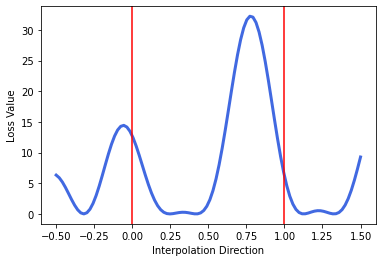

In [4]:
plot_1D_interpolation_result(scan1D_result)

Full flexibility if you create your own figure with axis

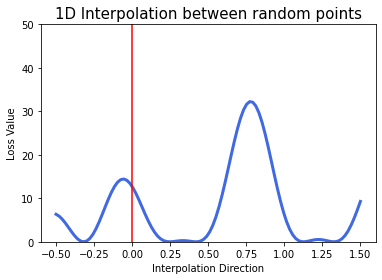

In [5]:
fig, ax = plt.subplots()
plot_1D_interpolation_result(scan1D_result, ax=ax)
ax.set_title("1D Interpolation between random points", fontsize=15)
ax.set_ylim(0, 50)
ax.lines[2].remove()
plt.show()

Performing 2D interpolation between the points

In [6]:
scan2D_result1 = perform_2D_interpolation(params1, params2, loss_function, n_steps_x=100, parameter_period=None)

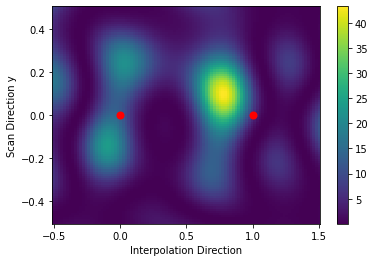

In [7]:
plot_2D_interpolation_result(scan2D_result1)

Wrapping the parameters according to $2\pi$ period

In [8]:
scan2D_result2 = perform_2D_interpolation(params1, params2, loss_function, n_steps_x=100, parameter_period=2*np.pi)

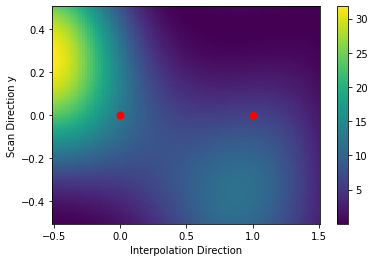

In [9]:
plot_2D_interpolation_result(scan2D_result2)

Perform 2D scans in random direction around the two parameter vectors.

In [10]:
scaling_factor = 2
dir1 = get_random_normal_vector(n_params)*scaling_factor
dir2 = get_random_orthonormal_vector(dir1)*scaling_factor

scan2D_around1 = perform_2D_scan(params1, loss_function, 
                                 direction_x=dir1, direction_y=dir2,
                                 n_steps_x=100)

scan2D_around2 = perform_2D_scan(params2, loss_function, 
                                 direction_x=dir1, direction_y=dir2,
                                 n_steps_x=100)

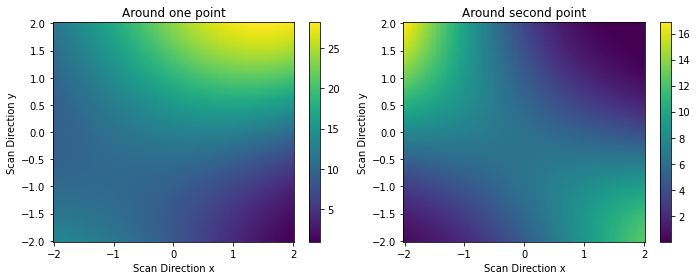

In [11]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))

plot_2D_scan_result(scan2D_around1, fig=fig, ax=ax1)
plot_2D_scan_result(scan2D_around2, fig=fig, ax=ax2)

ax1.set_title("Around one point")
ax2.set_title("Around second point")
plt.tight_layout()
plt.show()

Represent the plot in 3D

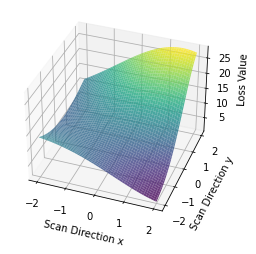

In [12]:
plot_2D_scan_result_as_3D(scan2D_around1)

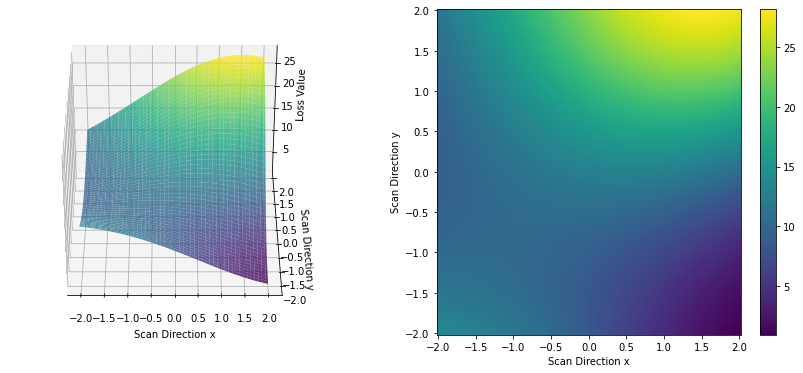

In [13]:
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(1, 2, 1, projection="3d")
plot_2D_scan_result_as_3D(scan2D_around1, ax=ax)
ax.view_init(elev=35, azim=-90)

ax2 = fig.add_subplot(1, 2, 2)
plot_2D_scan_result(scan2D_around1, fig=fig, ax=ax2)
plt.show()

Adding noise

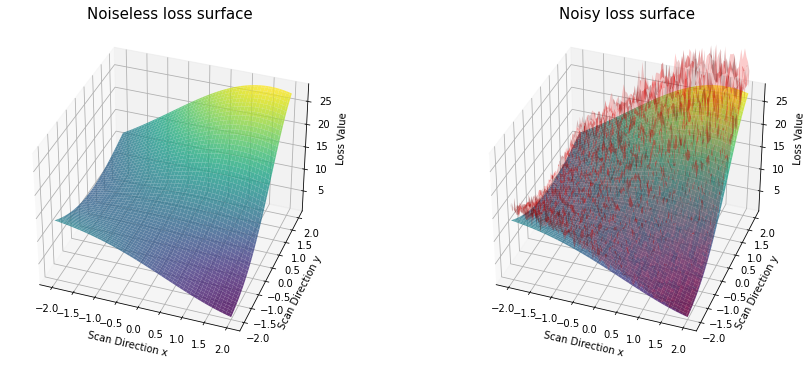

In [14]:
def noisy_loss_function(params):
    exact_loss = loss_function(params)
    noise = np.random.normal(0., 0.2)
    return exact_loss + exact_loss*noise

# generate noisy data
n_repetitions = 10

noisy_results = [perform_2D_scan(
    params1, noisy_loss_function, direction_x=dir1, direction_y=dir2, n_steps_x=100
) for _ in range(n_repetitions)]

losses = [result.values for result in noisy_results]
mean_Scan = clone_Scan2DResult_with_different_values(base_scan=scan2D_around1, values=np.mean(losses, axis=0))
std_Scan = clone_Scan2DResult_with_different_values(base_scan=scan2D_around1, values=np.mean(losses, axis=0) + np.std(losses, axis=0))

# plot it up
fig = plt.figure(figsize=(15,6))

ax1 = fig.add_subplot(1, 2, 1, projection="3d")
plot_2D_scan_result_as_3D(scan2D_around1, ax=ax1)

ax2 = fig.add_subplot(1, 2, 2, projection="3d")
plot_2D_scan_result_as_3D(scan2D_around1, ax=ax2)
plot_2D_scan_result_as_3D(std_Scan, ax=ax2, cmap=None, color="red", alpha=0.2)

ax2.set_zlim(ax1.get_zlim())
ax1.set_title("Noiseless loss surface", fontsize=15)
ax2.set_title("Noisy loss surface", fontsize=15)
plt.show()

## Now PCA on an optimization history

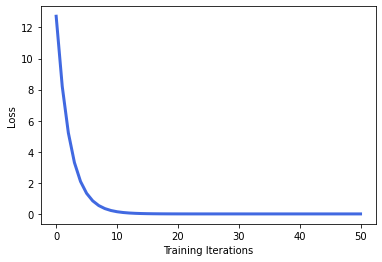

In [15]:
from gradient_descent_optimizer import gradient_descent_optimizer

gradient_function = lambda pars: calculate_full_gradient(pars, loss_function, eps=1e-3, stochastic=False)

parameter_trajectory, costs = gradient_descent_optimizer(init_params=params1, loss_function=loss_function, 
                                                         n_iters=50, learning_rate=0.02,
                                                         full_gradient_function=gradient_function)
    
final_params = parameter_trajectory[-1]
plt.plot(costs, color="royalblue", linewidth=3)
plt.ylabel("Loss")
plt.xlabel("Training Iterations")
plt.show()

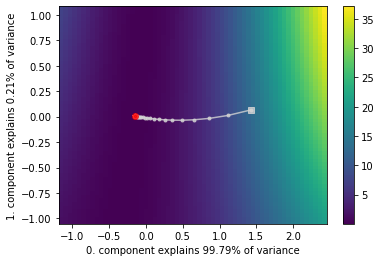

In [16]:
pca = get_pca(parameter_trajectory, components_ids=(0,1))
pca_scan_result = perform_2D_pca_scan(pca, loss_function, n_steps_x=60, offset=1)

plot_pca_landscape(pca_scan_result, pca)
plot_optimization_trajectory_on_pca(parameter_trajectory, pca)
plot_scatter_points_on_pca([final_params], pca, color="red", zorder=3, linewidth=4)
plt.show()

Plot higher components

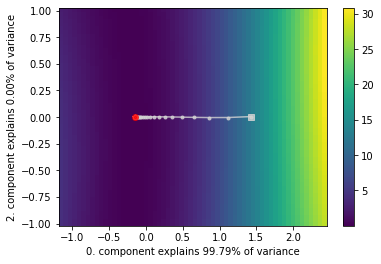

In [17]:
pca.set_component_ids((0,2))

pca_scan_result = perform_2D_pca_scan(pca, loss_function, n_steps_x=60, offset=1)
fig, ax = plt.subplots()
plot_pca_landscape(pca_scan_result, pca, fig=fig, ax=ax)
plot_optimization_trajectory_on_pca(parameter_trajectory, pca, ax=ax)
plot_scatter_points_on_pca([final_params], pca, ax=ax, color="red", zorder=3, linewidth=4)
plt.show()

### Scan around the minimum

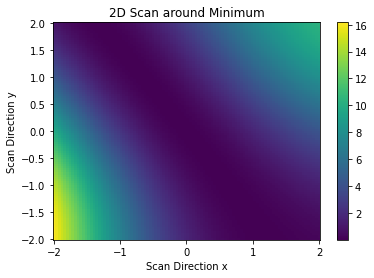

In [18]:
scaling_factor = 2
dir1 = get_random_normal_vector(n_params)*scaling_factor
dir2 = get_random_orthonormal_vector(dir1)*scaling_factor

scan2D_around = perform_2D_scan(final_params, loss_function, 
                                 direction_x=dir1, direction_y=dir2,
                                 n_steps_x=100)


plot_2D_scan_result(scan2D_around)

plt.title("2D Scan around Minimum")
plt.show()

## Explore the Hessians

Around a random point

In [19]:
params = np.random.uniform(-5, 5, size=n_params)
hessian = get_Hessian(params=params, loss_function=loss_function, n_reps=1, eps=1e-3)

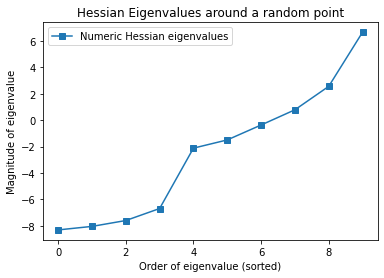

In [20]:
plt.plot(hessian.eigenvalues, label="Numeric Hessian eigenvalues", marker="s")
plt.legend()
plt.title("Hessian Eigenvalues around a random point")
plt.xlabel("Order of eigenvalue (sorted)")
plt.ylabel("Magnitude of eigenvalue")
plt.show()

Around the minimum where the Hessian should be positive semi-definite

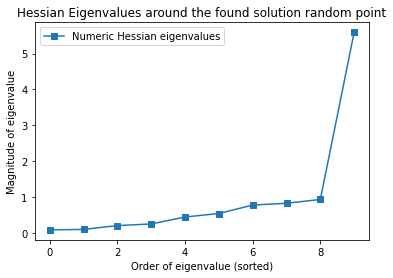

In [21]:
params = final_params
hessian = get_Hessian(params=params, loss_function=loss_function, n_reps=1, eps=1e-3)

plt.plot(hessian.eigenvalues, label="Numeric Hessian eigenvalues", marker="s")
plt.legend()
plt.title("Hessian Eigenvalues around the found solution random point")
plt.xlabel("Order of eigenvalue (sorted)")
plt.ylabel("Magnitude of eigenvalue")
plt.show()

Now define your own analytic gradient function

In [22]:
""" remember:
def loss_function(x):
    return np.sum(np.cos(x))**2
"""

def dloss_dparams(x, direction):
    dval = np.dot(-2*np.sin(x)*np.sum(np.cos(x)),direction)
    return dval  

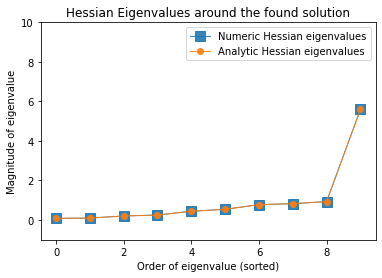

In [23]:
params = final_params

hessian_ana = get_Hessian(params=params, 
            loss_function=loss_function, 
            gradient_function=dloss_dparams, 
            n_reps=1,
            eps=1e-3)

plt.plot(hessian.eigenvalues, label="Numeric Hessian eigenvalues", alpha=0.9, linewidth=1, marker="s", ms=10)
plt.plot(hessian_ana.eigenvalues, label="Analytic Hessian eigenvalues", alpha=0.9, linewidth=1, marker="o")
plt.legend()
plt.ylim(-1,10)
plt.title("Hessian Eigenvalues around the found solution")
plt.xlabel("Order of eigenvalue (sorted)")
plt.ylabel("Magnitude of eigenvalue")
plt.show()

### And try the approximation

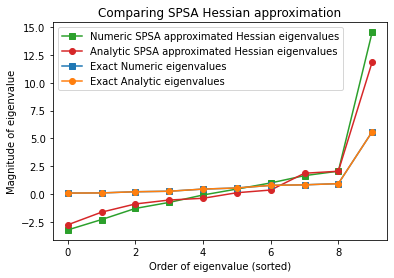

In [24]:
hessian_SPSA_num = get_Hessian_SPSA_approx(params=params, 
            loss_function=loss_function, 
            n_reps=100,   
            eps=1e-3)

plt.plot(hessian_SPSA_num.eigenvalues, label="Numeric SPSA approximated Hessian eigenvalues", marker="s", color="tab:green")

hessian_SPSA_ana = get_Hessian_SPSA_approx(params=params, 
            loss_function=loss_function, 
            gradient_function=dloss_dparams, 
            n_reps=100,   # if this goes to 1e5, it will become good
            eps=1e-3)

plt.plot(hessian_SPSA_ana.eigenvalues, label="Analytic SPSA approximated Hessian eigenvalues", marker="o", color="tab:red")
#
plt.plot(hessian.eigenvalues, label="Exact Numeric eigenvalues", marker="s", color="tab:blue")
plt.plot(hessian_ana.eigenvalues, label="Exact Analytic eigenvalues", marker="o", color="tab:orange")
#
plt.legend()
# plt.ylim(-1,10)
#
plt.title("Comparing SPSA Hessian approximation")
plt.xlabel("Order of eigenvalue (sorted)")
plt.ylabel("Magnitude of eigenvalue")
#
plt.show()

#### Now perform 2D scans with the use of the Hessian
First plotting the min eigenvalue. It should be positive in convex regions and otherwise reveal negative curvature that the loss scan might not show.

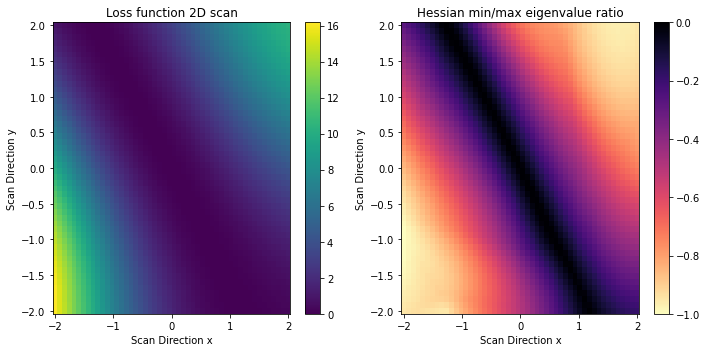

Wall time: 6.81 s


In [25]:
%%time
params = final_params

def calc_eigval_ratio(pars):
    hessian = get_Hessian(pars, loss_function, n_reps=1, eps=1e-3)
    return np.min(hessian.eigenvalues)/np.max(hessian.eigenvalues)


scan2D_around1 = perform_2D_scan(params, loss_function, 
                                 direction_x=dir1, direction_y=dir2,
                                 n_steps_x=50)

# use the directions of the first scan for the second one
scan2D_around1_hessratio = perform_2D_scan(params, calc_eigval_ratio, 
                                 direction_x=dir1, direction_y=dir2,
                                 n_steps_x=50)


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
plot_2D_scan_result(scan2D_around1, fig=fig, ax=ax1)
plot_2D_scan_result(scan2D_around1_hessratio, fig=fig, ax=ax2)
normalize_color_and_colorbar(cmap="magma_r", min_val=-1, max_val=0,
                             fig=fig, ax=ax2)
ax1.set_title("Loss function 2D scan")
ax2.set_title("Hessian min/max eigenvalue ratio")
plt.tight_layout()
plt.show()

And the analytic SPSA approximation?\
The it currently takes more measurements for the approximation to good than it takes to calcualte the Hessian exactly.

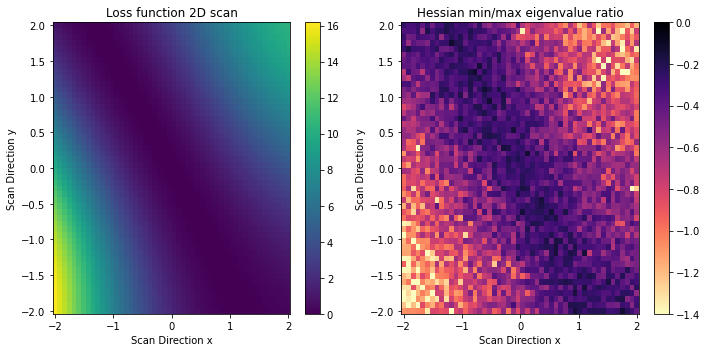

Wall time: 25 s


In [26]:
%%time

def calc_eigval_ratio_approx(pars):
    hessian = get_Hessian_SPSA_approx(pars, loss_function, gradient_function=dloss_dparams, 
                                      n_reps=100, eps=1e-3)
    return np.min(hessian.eigenvalues)/np.max(hessian.eigenvalues)


# use the directions of the first scan for the second one
scan2D_around1_hessratio_approx = perform_2D_scan(params, calc_eigval_ratio_approx, 
                                 direction_x=dir1, direction_y=dir2,
                                 n_steps_x=50)


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
plot_2D_scan_result(scan2D_around1, fig=fig, ax=ax1)
plot_2D_scan_result(scan2D_around1_hessratio_approx, fig=fig, ax=ax2)
normalize_color_and_colorbar(cmap="magma_r", min_val=-1.4, max_val=0,
                             fig=fig, ax=ax2)
ax1.set_title("Loss function 2D scan")
ax2.set_title("Hessian min/max eigenvalue ratio")
plt.tight_layout()
plt.show()

Hessians are expensive, so lets save the scans

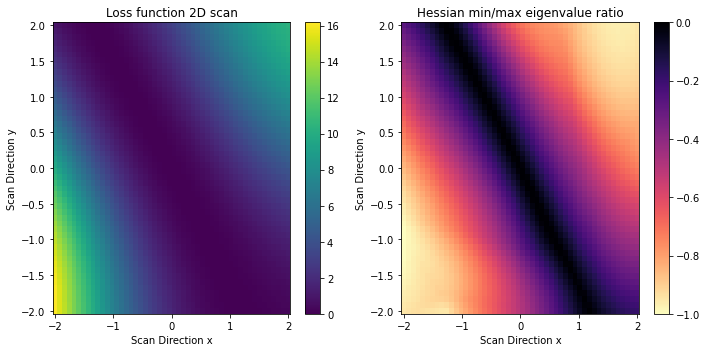

In [27]:
save_viz_object(scan2D_around1, "loss_scan")
save_viz_object(scan2D_around1_hessratio, "hessian_scan")

loaded_loss_scan = load_viz_object("loss_scan")
loaded_hess_scan = load_viz_object("hessian_scan")

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
plot_2D_scan_result(loaded_loss_scan, fig=fig, ax=ax1)
plot_2D_scan_result(loaded_hess_scan, fig=fig, ax=ax2)
normalize_color_and_colorbar(cmap="magma_r", min_val=-1.0, max_val=0.0,
                             fig=fig, ax=ax2)
ax1.set_title("Loss function 2D scan")
ax2.set_title("Hessian min/max eigenvalue ratio")
plt.tight_layout()
plt.show()

### Now utilize the Eigenvectors to chose measurement directions
First for 1D scans

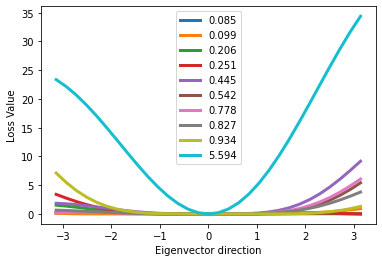

In [28]:
hessian = get_Hessian(params=params, loss_function=loss_function, n_reps=1, eps=1e-3)

list_of_scans = perform_1D_hessian_eigenvector_scan(hessian, loss_function)
plot_1D_hessian_eigenvector_scan_result(list_of_scans, hessian.eigenvalues)

Also Hessians themselves can be saved

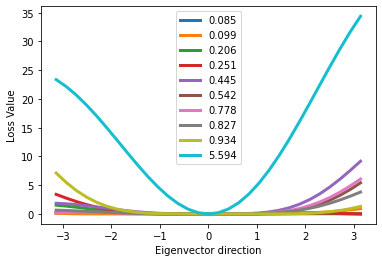

In [29]:
save_viz_object(hessian, "./test_hessian")
loaded_hessian = load_viz_object("./test_hessian") 

list_of_scans = perform_1D_hessian_eigenvector_scan(loaded_hessian, loss_function)
plot_1D_hessian_eigenvector_scan_result(list_of_scans, loaded_hessian.eigenvalues)

Now for 2D scans

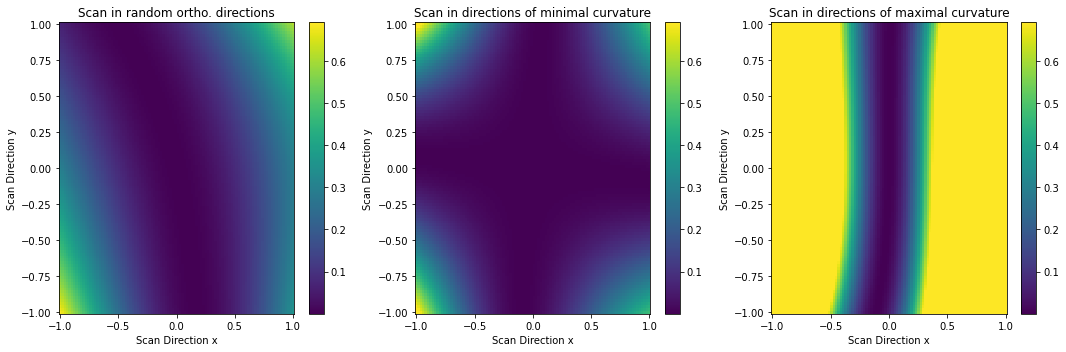

In [30]:
# %%time

dir1 = get_random_normal_vector(n_params)
dir2 = get_random_orthonormal_vector(dir1)

scan2D_around1 = perform_2D_scan(final_params, loss_function, 
                                 direction_x=dir1, direction_y=dir2,
                                 n_steps_x=100)

hessian = get_Hessian(params=params, loss_function=loss_function, n_reps=1, eps=1e-3)

scan2D_around2 = perform_2D_scan(final_params, loss_function, 
                                 direction_x=hessian.eigenvectors[0], direction_y=hessian.eigenvectors[1],
                                 n_steps_x=100)
scan2D_around3 = perform_2D_scan(final_params, loss_function, 
                                 direction_x=hessian.eigenvectors[-1], direction_y=hessian.eigenvectors[-2],
                                 n_steps_x=100)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
plot_2D_scan_result(scan2D_around1, fig=fig, ax=ax1)
plot_2D_scan_result(scan2D_around2, fig=fig, ax=ax2)
plot_2D_scan_result(scan2D_around3, fig=fig, ax=ax3)


normalize_color_and_colorbar(fig=fig, ax=ax1, min_val=np.min(scan2D_around1.values), max_val=np.max(scan2D_around1.values))
normalize_color_and_colorbar(fig=fig, ax=ax2, min_val=np.min(scan2D_around1.values), max_val=np.max(scan2D_around1.values))
normalize_color_and_colorbar(fig=fig, ax=ax3, min_val=np.min(scan2D_around1.values), max_val=np.max(scan2D_around1.values))

ax1.set_title("Scan in random ortho. directions")
ax2.set_title("Scan in directions of minimal curvature")
ax3.set_title("Scan in directions of maximal curvature")
plt.tight_layout()
plt.show()

### PCA on two runs
Grab another minimum

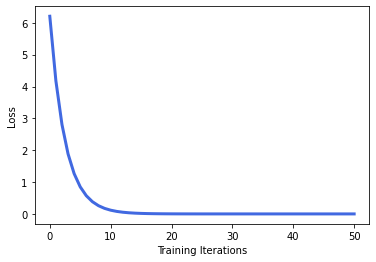

In [31]:
from gradient_descent_optimizer import gradient_descent_optimizer

gradient_function = lambda pars: calculate_full_gradient(pars, loss_function, eps=1e-3, stochastic=False)

parameter_trajectory2, costs2 = gradient_descent_optimizer(init_params=params2, loss_function=loss_function, 
                                                         n_iters=50, learning_rate=0.02,
                                                         full_gradient_function=gradient_function)
    
final_params2 = parameter_trajectory2[-1]
plt.plot(costs2, color="royalblue", linewidth=3)
plt.ylabel("Loss")
plt.xlabel("Training Iterations")
plt.show()

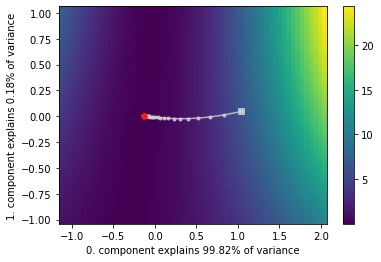

In [32]:
pca2 = get_pca(parameter_trajectory2)
pca_scan_result = perform_2D_pca_scan(pca2, loss_function, n_steps_x=60, offset=1)

fig, ax = plt.subplots()
plot_pca_landscape(pca_scan_result, pca2, fig=fig, ax=ax)
plot_optimization_trajectory_on_pca(parameter_trajectory2, pca2, ax=ax)
plot_scatter_points_on_pca([final_params2], pca2, ax=ax, color="red", zorder=3, linewidth=4)
plt.show()

### Elastic Band

Create the linear path between the two minima.

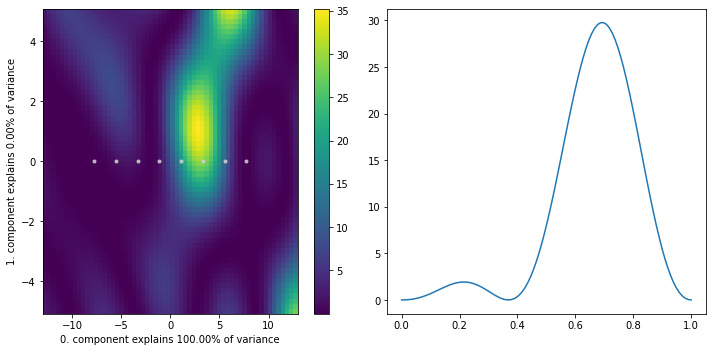

In [33]:
inter_pars = np.linspace(final_params, final_params2, num=8)
linear_chain = Chain(inter_pars)
linear_path = ChainPath(linear_chain)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

pca = get_pca(linear_chain.pivots)
pca_scan_result = perform_2D_pca_scan(pca, loss_function, n_steps_x=60, offset=5)
plot_pca_landscape(pca_scan_result, pca, fig=fig, ax=ax1)
plot_scatter_points_on_pca(linear_chain.pivots, pca, ax=ax1)


lin_loss = linear_path.evaluate_points_on_path(100, loss_function)
ax2.plot(np.linspace(0, 1, len(lin_loss)), lin_loss)
plt.tight_layout()
plt.show()

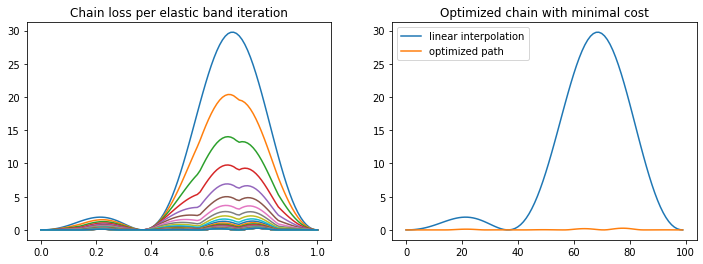

In [34]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4))
##
all_chains = run_NEB(linear_chain, loss_function, n_iters=50, learning_rate=0.02, eps=1e-3, stochastic=False, calibrate_tangential=False)
for chain in all_chains:
    chain_path = ChainPath(chain)
    chain_loss = chain_path.evaluate_points_on_path(100, loss_function)
    ax1.plot(np.linspace(0,1,len(chain_loss)), chain_loss)
#
trained_chain = all_chains[-1]    
trained_path = ChainPath(trained_chain)
#
ax2.plot(linear_path.evaluate_points_on_path(100, loss_function), label="linear interpolation")
ax2.plot(trained_path.evaluate_points_on_path(100, loss_function), label="optimized path")
#
ax1.set_title("Chain loss per elastic band iteration")
ax2.set_title("Optimized chain with minimal cost")
# ax3.set_title("Linear chain loss vs optimized chain loss")
plt.legend()
# plt.tight_layout()
plt.show()

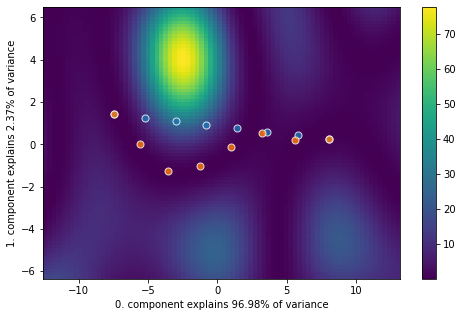

In [35]:
fig, ax = plt.subplots(figsize=(8,5))
pca = get_pca(trained_chain.pivots)
pca_scan_result = perform_2D_pca_scan(pca, loss_function, n_steps_x=80, offset=5)
plot_pca_landscape(pca_scan_result, pca, fig=fig, ax=ax)
plot_scatter_points_on_pca(linear_chain.pivots, pca, ax=ax, color="tab:blue", s=200, edgecolor="white")
plot_scatter_points_on_pca(trained_chain.pivots, pca, ax=ax, color="tab:orange", s=200, edgecolor="white")


### AutoNEB

In [36]:
short_linear_chain = linear_path.generate_uniform_chain(5)
all_chains_weighted = run_AutoNEB(short_linear_chain, loss_function, n_cycles=5, n_iters_per_cycle=10, max_new_pivots=1, learning_rate=0.02,
                             weighted_redistribution=True)
all_chains = run_AutoNEB(short_linear_chain, loss_function, n_cycles=5, n_iters_per_cycle=10, max_new_pivots=1, learning_rate=0.02,
                    weighted_redistribution=False)

#
trained_chain = all_chains[-1]
trained_weighted_chain = all_chains_weighted[-1]
trained_path = ChainPath(trained_chain)
trained_weighted_path = ChainPath(trained_weighted_chain)

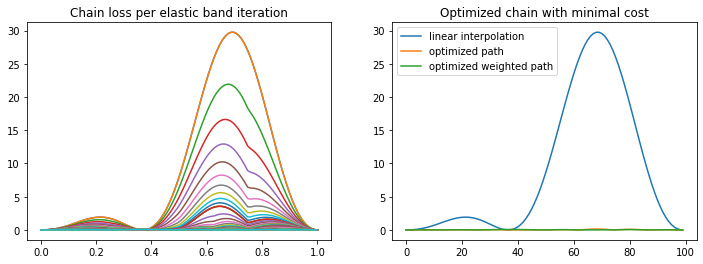

In [37]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4))
##
for chain in all_chains_weighted:
    chain_path = ChainPath(chain)
    chain_loss = chain_path.evaluate_points_on_path(n_points=100, loss_function=loss_function)
    ax1.plot(np.linspace(0,1,len(chain_loss)), chain_loss)
#
ax2.plot(linear_path.evaluate_points_on_path(100, loss_function), label="linear interpolation")
ax2.plot(trained_path.evaluate_points_on_path(100, loss_function), label="optimized path")
ax2.plot(trained_weighted_path.evaluate_points_on_path(100, loss_function), label="optimized weighted path")
#
ax1.set_title("Chain loss per elastic band iteration")
ax2.set_title("Optimized chain with minimal cost")
plt.legend()
plt.show()

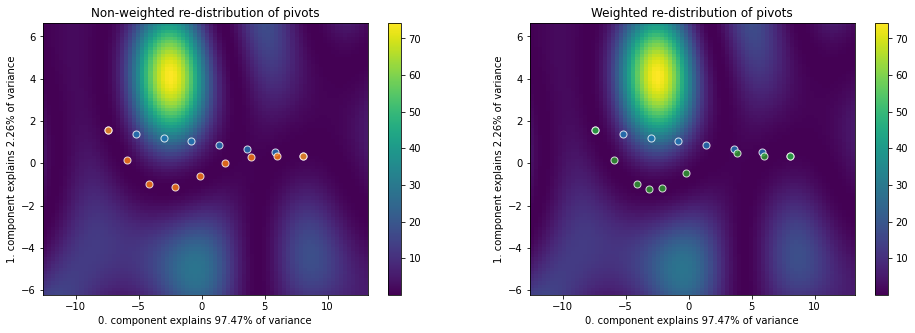

In [38]:
pca = get_pca(trained_chain.pivots)
pca_scan_result = perform_2D_pca_scan(pca, loss_function, n_steps_x=80, offset=5)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
plot_pca_landscape(pca_scan_result, pca, fig=fig, ax=ax1)
plot_pca_landscape(pca_scan_result, pca, fig=fig, ax=ax2)
plot_scatter_points_on_pca(linear_chain.pivots, pca, ax=ax1, color="tab:blue", s=200, edgecolor="white")
plot_scatter_points_on_pca(linear_chain.pivots, pca, ax=ax2, color="tab:blue", s=200, edgecolor="white")
plot_scatter_points_on_pca(trained_chain.pivots, pca, ax=ax1, color="tab:orange", s=200, edgecolor="white")
plot_scatter_points_on_pca(trained_weighted_chain.pivots, pca, ax=ax2, color="tab:green", s=200, edgecolor="white")

ax1.set_title("Non-weighted re-distribution of pivots")
ax2.set_title("Weighted re-distribution of pivots")
plt.show()

### Periodic wrap!
But respecting the symmetries is important! They are make these two points much closer.

In [39]:
pars2 = relative_periodic_wrap(final_params, final_params2, period=2*np.pi)

inter_pars = np.linspace(final_params, pars2, num=5)
linear_chain = Chain(inter_pars)
linear_path = ChainPath(linear_chain)

all_chains_weighted = run_AutoNEB(linear_chain, loss_function, n_cycles=5, n_iters_per_cycle=10, max_new_pivots=1, learning_rate=0.02,
                             weighted_redistribution=True)
all_chains = run_AutoNEB(linear_chain, loss_function, n_cycles=5, n_iters_per_cycle=10, max_new_pivots=1, learning_rate=0.02,
                    weighted_redistribution=False)

#
trained_chain = all_chains[-1]
trained_weighted_chain = all_chains_weighted[-1]
trained_path = ChainPath(trained_chain)
trained_weighted_path = ChainPath(trained_weighted_chain)

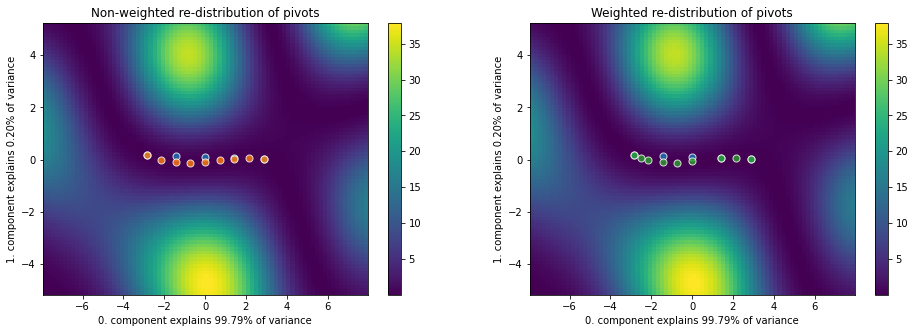

In [40]:
pca = get_pca(trained_chain.pivots)
pca_scan_result = perform_2D_pca_scan(pca, loss_function, n_steps_x=80, offset=5)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
plot_pca_landscape(pca_scan_result, pca, fig=fig, ax=ax1)
plot_pca_landscape(pca_scan_result, pca, fig=fig, ax=ax2)
plot_scatter_points_on_pca(linear_chain.pivots, pca, ax=ax1, color="tab:blue", s=200, edgecolor="white")
plot_scatter_points_on_pca(linear_chain.pivots, pca, ax=ax2, color="tab:blue", s=200, edgecolor="white")
plot_scatter_points_on_pca(trained_chain.pivots, pca, ax=ax1, color="tab:orange", s=200, edgecolor="white")
plot_scatter_points_on_pca(trained_weighted_chain.pivots, pca, ax=ax2, color="tab:green", s=200, edgecolor="white")

ax1.set_title("Non-weighted re-distribution of pivots")
ax2.set_title("Weighted re-distribution of pivots")
plt.show()